In [1]:
import pandas as pd
from util import *
from stationUtil import *
from graph import *

len(subway_graph) == len(interval_time) :  True


In [2]:
DF_METRIC=pd.read_json(("../database/METRIC_INTEGRATED.json"))
DF_METRIC.head()

,FLUX,IMPLICIT,LINE,GRADE
95,4.500,0.750000,1,3
96,1.875,1.666667,1,5
97,3.000,3.250000,1,4
98,1.000,4.916667,1,3
99,1.500,5.000000,1,3


In [3]:
GRADE_CONDITION = [DF_METRIC["GRADE"] == g for g in (1, 2, 3, 4, 5)]
LINE_CONDITION = [DF_METRIC["LINE"] == l for l in (1, 2, 3, 4)]

In [4]:
END_OF_STATION = [95, 134, 201, 243, 301, 317, 401, 414]

def draw_func(LINE):
    ax = DF_METRIC[LINE_CONDITION[LINE - 1]].plot.scatter(
        x="FLUX", y="IMPLICIT", c="GRADE", colormap="RdBu"
    )
    return ax, ax.get_figure()


def get_grade(LINE, GRADE):
    arr = []
    for g in range(GRADE):
        arr.extend(
            DF_METRIC[LINE_CONDITION[LINE - 1] & GRADE_CONDITION[g - 1]].index.to_list()
        )
    
    arr.sort()

    return arr


def get_exclude_list(LINE, GRADE):
    sCodes = [*line_num_to_range(LINE)]
    for grade in get_grade(LINE, GRADE):
        if grade in sCodes:
            sCodes.pop(sCodes.index(grade))

    if [*line_num_to_range(LINE)][0] in sCodes:
        sCodes.pop(0)
    if [*line_num_to_range(LINE)][-1] in sCodes:
        sCodes.pop(-1)
        
    return sCodes


assert 0 == len(set(get_grade(1, 1)) & set(get_exclude_list(1, 1)))

LINE, GRADE = (2, 5)
32.29 [km/h]
5040 [second]
[201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243] is Selected by GRADE 5 
[] ... and more will be exclude


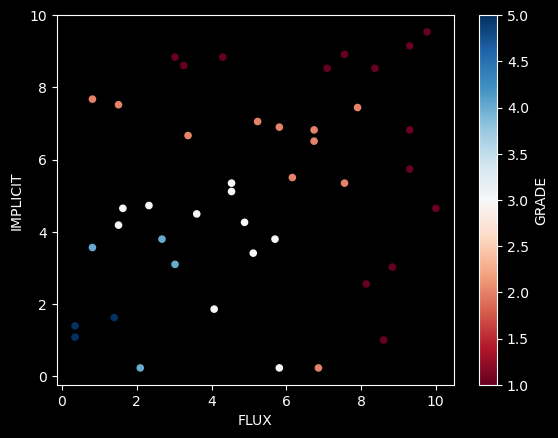

In [5]:
LINE,GRADE=(2,5)
EXCLUDE_STATION = get_exclude_list(LINE,GRADE)
g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
g_dist = dist_weight_graph()

draw_func(LINE)

print(
f"""LINE, GRADE = {LINE, GRADE}
{calc_line_speed(LINE,g_dist=g_dist,g_time=g_time):.2f} [km/h]
{calc_line_spend_time(LINE,g_time=g_time)} [second]
{get_grade(LINE,GRADE)} is Selected by GRADE {GRADE} 
{get_exclude_list(LINE, GRADE)[:5] if len(get_exclude_list(LINE, GRADE)) > 5 else get_exclude_list(LINE, GRADE)} ... and more will be exclude"""
)

In [6]:
df_senario = pd.DataFrame(columns=["TIME", "SPEED", "LINE", "GRADE"])
for line in [1, 2, 3, 4]:
    for grade in [5, 4, 3, 2, 1]:
        EXCLUDE_STATION = get_exclude_list(line, grade)
        g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
        g_dist = dist_weight_graph()

        df_line = (
            calc_line_spend_time(line, g_time),
            calc_line_speed(line, g_dist, g_time),
            line,
            grade,
        )
        df_senario.loc[len(df_senario.index)] = df_line

df_senario = df_senario.sort_values(by=["LINE", "GRADE"])
df_senario["LINE"] = df_senario["LINE"].apply(int)
df_senario["GRADE"] = df_senario["GRADE"].apply(int)

df_senario.to_json("../database/SENARIO.json")
df_senario

,TIME,SPEED,LINE,GRADE
4,3785.0,37.949802,1,1
3,4185.0,34.322581,1,2
2,4415.0,32.534541,1,3
1,4645.0,30.923574,1,4
0,4745.0,30.271865,1,5
9,4220.0,38.559242,2,1
8,4540.0,35.841410,2,2
7,4740.0,34.329114,2,3
6,4980.0,32.674699,2,4
5,5040.0,32.285714,2,5


In [7]:
def GET_dictionary_graph():
    # Load Graph
    _, subway_graph = fn_export_subway_graph(loadPickle(PATH_INTER_STATION_SPEND_TIME))
    interval = loadPickle(PATH_WEIGHTED_MEAN_INTERVAL)

    GRAPH = {}
    for index, value in subway_graph.items():
        value["dispatchingTime"] = interval[index[0]]
        GRAPH[index] = value
    return GRAPH


def GET_logical_graph(exclude_list=[], graph=GET_dictionary_graph()):
    # 정차역에 따른 그래프 생성
    subway_d_graph = dist_weight_graph(new_subway_graph=graph)
    subway_t_graph = time_weight_graph(
        new_subway_graph=graph, exclude_list=exclude_list
    )

    return subway_d_graph, subway_t_graph


def GET_muti_index_combination_list(li=[]):
    if len(li) == 0:
        return li
    m_idx = []
    for s1 in li:
        for s2 in li:
            if s1 == s2:
                continue

            m_idx.append((s1, s2))
    return m_idx


kwarg = {"UNITFACTOR_P1KM_TO_1KM": 0.1}


def GET_line_passenger_portion(
    line_num, SUBWAY_OD: dict, grade=5, graph=GET_dictionary_graph(), **kwarg
):
        
    passenger_portion = {
        "EXPRESS": 0,
        "NORMAL": 0,
    }

    line_scode_muti_indices = GET_muti_index_combination_list(
        line_num_to_range(line_num)
    )
    grade_list = get_grade(line_num, grade)
    grade_m_indice = GET_muti_index_combination_list(grade_list)

    check_full = 0
    for m_idx, passenger_num in SUBWAY_OD.items():
        # #호선이 아니면 넘김
        if not (m_idx in line_scode_muti_indices):
            continue

        # 급행열차를 타면이득인 승객의 수
        if m_idx in grade_m_indice:
            # passenger_portion["EXPRESS"] += passenger_num
            passenger_portion["EXPRESS"] += passenger_num / 2
            passenger_portion["NORMAL"] += passenger_num / 2
        if not (m_idx in grade_m_indice):
            passenger_portion["NORMAL"] += passenger_num

        check_full += passenger_num

    assert int(check_full) == int(
        passenger_portion["NORMAL"] + passenger_portion["EXPRESS"]
    ), f'{int(check_full)} != {int(passenger_portion["NORMAL"] + passenger_portion["EXPRESS"])}'

    passenger_portion["EXPRESS"] = int(passenger_portion["EXPRESS"])
    passenger_portion["NORMAL"] = int(passenger_portion["NORMAL"])
    if grade == 5:
        return {"EXPRESS":0,"NORMAL":passenger_portion["EXPRESS"]+passenger_portion["NORMAL"]}
    return passenger_portion

len(subway_graph) == len(interval_time) :  True
len(subway_graph) == len(interval_time) :  True


In [52]:
END_OF_STATION = [95, 134, 201, 243, 301, 317, 401, 414]
def GET_line_transfer_time(
    line_num, SUBWAY_OD: dict, grade=5, graph=GET_dictionary_graph(), **kwarg
):

    passenger_portion = {
        "EXPRESS_T": 0,
        "NORMAL_T": 0,
    }

    _, T_GRAPH = GET_logical_graph(exclude_list=get_exclude_list(line_num, grade))
    _, T_RAW_GRAPH = GET_logical_graph(exclude_list=[])
    line_scode_muti_indices = GET_muti_index_combination_list(
        line_num_to_range(line_num)
    )
    grade_list = get_grade(line_num, grade)
    
    if line_num == 1 and (not(95 in grade_list) or not(134 in grade_list)):
        grade_list.extend([95,134])
    if line_num == 2 and (not(201 in grade_list) or not(243 in grade_list)):
        grade_list.extend([201, 243])
    if line_num == 3 and (not(301 in grade_list) or not(317 in grade_list)):
        grade_list.extend([301, 317])
    if line_num == 4 and (not(401 in grade_list) or not(414 in grade_list)):
        grade_list.extend([401, 414])    
        
    grade_m_indice = GET_muti_index_combination_list(grade_list)
    

    check_full = 0
    for m_idx, passenger_num in SUBWAY_OD.items():
        # #호선이 아니면 넘김
        if not (m_idx in line_scode_muti_indices):
            continue

        min_path = T_GRAPH.find_min_path(*m_idx)
        time_spend = T_GRAPH.calculate_path_weight(min_path)
        
        min_normal_path = T_RAW_GRAPH.find_min_path(*m_idx)
        time_normal_spend = T_RAW_GRAPH.calculate_path_weight(min_normal_path)

        
        # 급행열차를 타면이득인 승객의 수
        if m_idx in grade_m_indice:
            # passenger_portion["EXPRESS_T"] += passenger_num
            passenger_portion["EXPRESS_T"] += passenger_num / 2 * time_spend
            passenger_portion["NORMAL_T"] += passenger_num / 2 * time_normal_spend
        if not (m_idx in grade_m_indice):
            passenger_portion["NORMAL_T"] += passenger_num * time_normal_spend

        check_full += passenger_num

    passenger_portion["EXPRESS_T"] = int(passenger_portion["EXPRESS_T"])
    passenger_portion["NORMAL_T"] = int(passenger_portion["NORMAL_T"])
    if grade == 5:
        return {"EXPRESS_T": 0, "NORMAL_T": passenger_portion["EXPRESS_T"]+passenger_portion["NORMAL_T"]}
    return passenger_portion

len(subway_graph) == len(interval_time) :  True


In [58]:
100 * (1 - 93164709968 / 94988895792), get_grade(1, 2)
# 100 * (1 - 73237135533 / 74639013358), get_grade(2, 2)
# 100 * (1 - 4642215080 / 4722657008), get_grade(3, 2)
# 100 * (1 - 535807377 / 552007022), get_grade(4, 3)

(1.9204200751996026,
 [96, 102, 110, 111, 113, 118, 119, 120, 122, 123, 124, 125, 128, 134])

In [59]:
def GET_passenger(line_num, grade, od=SUBWAY_OD_RAW, **kwarg):
    tmp_1 = GET_line_transfer_time(
        line_num=line_num, grade=grade, SUBWAY_OD=od, **kwarg
    )
    tmp_2 = GET_line_passenger_portion(
        line_num=line_num, grade=grade, SUBWAY_OD=od, **kwarg
    )
    return tmp_2, tmp_1,tmp_1["EXPRESS_T"]+tmp_1["NORMAL_T"]

for l in [1,2,3,4]:
    for g in [1,2,3,4,5]:
        print((l,g),GET_passenger(line_num=l, grade=g, **kwarg))

(1, 1) ({'EXPRESS': 0, 'NORMAL': 65486802}, {'EXPRESS_T': 153807466, 'NORMAL_T': 94795040786}, 94948848252)
(1, 2) ({'EXPRESS': 9642580, 'NORMAL': 55844222}, {'EXPRESS_T': 13141046084, 'NORMAL_T': 80023663884}, 93164709968)
(1, 3) ({'EXPRESS': 17482832, 'NORMAL': 48003969}, {'EXPRESS_T': 23866810619, 'NORMAL_T': 69881210657}, 93748021276)
(1, 4) ({'EXPRESS': 26916928, 'NORMAL': 38569873}, {'EXPRESS_T': 37365727052, 'NORMAL_T': 57092196350}, 94457923402)
(1, 5) ({'EXPRESS': 0, 'NORMAL': 65486802}, {'EXPRESS_T': 0, 'NORMAL_T': 94988895792}, 94988895792)
(2, 1) ({'EXPRESS': 2247, 'NORMAL': 46971991}, {'EXPRESS_T': 210496445, 'NORMAL_T': 74395296908}, 74605793353)
(2, 2) ({'EXPRESS': 7958835, 'NORMAL': 39015402}, {'EXPRESS_T': 11740154892, 'NORMAL_T': 61496980641}, 73237135533)
(2, 3) ({'EXPRESS': 14824663, 'NORMAL': 32149574}, {'EXPRESS_T': 21561441198, 'NORMAL_T': 51975088016}, 73536529214)
(2, 4) ({'EXPRESS': 21585513, 'NORMAL': 25388724}, {'EXPRESS_T': 33683829117, 'NORMAL_T': 40564454

In [10]:
SUBWAY_OD_RAW = loadPickle("../database/SUBWAY_OD_RAW.pkl")
passenger = GET_line_transfer_time(
    line_num=3, grade=2, SUBWAY_OD=SUBWAY_OD_RAW, **kwarg
)
passenger = GET_line_passenger_portion(
    line_num=3, grade=2, SUBWAY_OD=SUBWAY_OD_RAW, **kwarg
)
passenger_population = passenger["EXPRESS"] + passenger["NORMAL"]
passenger_population = 1
(
    passenger["EXPRESS"]/passenger_population,
    passenger["NORMAL"]/passenger_population,
)

(873183.0, 4197660.0)

In [ ]:
for l in [1,2,3,4]:
    for g in [1,2,3,4,5]:
        print(GET_line_passenger_portion(line_num=l,grade=g,SUBWAY_OD=SUBWAY_OD_RAW,**kwarg))

{'EXPRESS': 0, 'NORMAL': 65486802}
{'EXPRESS': 9642580, 'NORMAL': 55844222}
{'EXPRESS': 17482832, 'NORMAL': 48003969}
{'EXPRESS': 26916928, 'NORMAL': 38569873}
{'EXPRESS': 32743401, 'NORMAL': 32743401}
{'EXPRESS': 2247, 'NORMAL': 46971991}
{'EXPRESS': 7958835, 'NORMAL': 39015402}
{'EXPRESS': 14824663, 'NORMAL': 32149574}
{'EXPRESS': 21585513, 'NORMAL': 25388724}
{'EXPRESS': 23487119, 'NORMAL': 23487119}
{'EXPRESS': 263, 'NORMAL': 5070580}
{'EXPRESS': 873183, 'NORMAL': 4197660}
{'EXPRESS': 1732287, 'NORMAL': 3338555}
{'EXPRESS': 2259888, 'NORMAL': 2810954}
{'EXPRESS': 2535421, 'NORMAL': 2535421}
{'EXPRESS': 0, 'NORMAL': 726233}
{'EXPRESS': 54497, 'NORMAL': 671735}
{'EXPRESS': 237300, 'NORMAL': 488933}
{'EXPRESS': 359198, 'NORMAL': 367035}
{'EXPRESS': 363116, 'NORMAL': 363116}


In [61]:
senario_selected = [
    (1, 2),
    (2, 2),
    (3, 2),
    (4, 3),
]

print(
    get_grade(*senario_selected[0]),
    get_grade(*senario_selected[1]),
    get_grade(*senario_selected[2]),
    get_grade(*senario_selected[3]),
    sep="\n"
)

[96, 102, 110, 111, 113, 118, 119, 120, 122, 123, 124, 125, 128, 134]
[201, 202, 203, 206, 208, 212, 216, 217, 218, 219, 220, 227, 235, 237, 238, 239, 243]
[301, 305, 306, 309, 313, 315, 316, 317]
[401, 402, 403, 404, 405, 406, 411, 412, 413, 414]


In [75]:
s_namecode = loadPickle("../trimmed_data/stationNameCode.pickel")
tmp = [[],[],[],[]]
for i in [1,2,3,0]:
    grade = get_grade(*senario_selected[i])
    for key,val in s_namecode.items():
        for g in grade:
            if val == g:
                tmp[i].append(key[1])

In [ ]:
['다대포항', '하단', '자갈치', '남포', '부산역', '범내골', '서면', '부전', '시청', '연산', '교대', '동래', '부산대', '노포'],
['장산', '중동', '해운대', '센텀시티', '수영', '경성대.부경대', '문현', '국제금융.부산은행', '전포', '서면', '부암', '사상', '화명', '동원', '금곡', '호포', '양산'],
['수영', '연산', '거제', '미남', '덕천', '강서구청', '체육공원', '대저'],
['미남', '동래', '수안', '낙민', '충렬사', '명장', '영산대', '윗반송', '고촌', '안평']